# Installing cuDF for CUDA Operations
___

In [25]:
!nvidia-smi

Sun Aug  3 06:53:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   77C    P0             32W /   70W |    3699MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [26]:
!pip install cudf-cu12

In [27]:
%reload_ext cudf.pandas

# Importing Libraries
___

In [28]:
# Data Libraries
import pandas as pd                # Dataset Handling
import numpy as np                 # Linear Algebra
import math                        # Mathematical Operations
from collections import Counter    # Counter Dictionary
from PIL import Image              # Image Class
import os                          # Operating System
import string                      # String Operations
import cudf
from tqdm import tqdm_notebook

# Regular Expression
import re

# Graphing Libraries
import matplotlib.pyplot as plt    # Graphing/Plotting
import seaborn as sns              # Better Plots

# Preprocessing Libraries
from sklearn.model_selection import train_test_split    # Train/Test Data Splitting
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

# Neural Network Libraries
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, add
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Evaluation Metric
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction    # BLEU Score

# Warnings Library
import warnings                      # Main Library
warnings.filterwarnings("ignore")    # Suppressing All Warnings

# Handling the Data
___

## Read the Data

In [29]:
images_directory = '/kaggle/input/flickr8k/Images/'
captions_path = '/kaggle/input/flickr8k/captions.txt'
def load_captions (file_path):
    with open (file_path, 'r') as f:
        captions = f.readlines()
        captions = [caption.lower() for caption in captions[1:]]
    return captions
def tokenize_captions (captions):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts (captions)
    return tokenizer
captions = load_captions (captions_path)

In [30]:
def clean_text (text):
    text = re.sub (r'[^\w\s]', '', text)
    text = re.sub (r'\d+', '', text)
    text = re.sub (r'\s+', ' ', text).strip()
    text = text.lower()
    return text

In [31]:
cleaned_captions = [clean_text(caption.split(',')[1]) for caption in captions]

In [32]:
captions_IDs = []
for i in range (len(cleaned_captions)):
    item = captions[i].split(',')[0]+'\t'+'start '+cleaned_captions[i]+' end\n'
    captions_IDs.append (item)

In [33]:
def tokenize (text):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(text)
    return tokenizer
tokenizer = tokenize (cleaned_captions)
vocab_size = len (tokenizer.word_index) + 1
max_caption_length = max(len(seq) for seq in tokenized)
vocab_size

8586

In [34]:
Image_IDs = os.listdir (images_directory)
Train_Image_IDs, Value_Image_IDs = train_test_split (Image_IDs, test_size = 0.15, random_state = 42)
Value_Image_IDs, Test_Image_IDs = train_test_split(Value_Image_IDs, test_size = 0.1, random_state = 42)
train_captions, value_captions, test_captions = [], [], []
for caption in captions_IDs:
    image_ID, _ = caption.split ('\t')
    if image_ID in Train_Image_IDs:
        train_captions.append (caption)
    elif image_ID in Value_Image_IDs:
        value_captions.append (caption)
    elif image_ID in Test_Image_IDs:
        test_captions.append (caption)
    else:
        print ('Unknown image ID !')

In [35]:
def preprocessing_images (image_path):
    img = load_img (image_path, target_size = (299, 299))
    img = img_to_array (img)
    img = np.expand_dims (img, axis = 0)
    img = tf.keras.applications.inception_v3.preprocess_input (img)
    return img
def extract_image_features (model, image_path):
    img = preprocessing_images (image_path)
    features = model.predict (img, verbose = 0)
    return features

In [36]:
InceptionV3_model = InceptionV3(weights = 'imagenet', input_shape = (299, 299, 3))
InceptionV3_model.layers.pop()
InceptionV3_model = Model (inputs = InceptionV3_model.inputs, outputs = InceptionV3_model.layers[-2].output)
cnn_output_dim = InceptionV3_model.output_shape[1]

In [37]:
Train_Image_Features, Value_Image_Features, Test_Image_Features = {}, {}, {}
pbar = tqdm_notebook (total = len (Image_IDs), position = 0, leave = True, colour = 'green')
for caption in Image_IDs:
    image_ID = caption.split ('\t')[0]
    image_path = os.path.join (images_directory, image_ID)
    image_features = extract_image_features (InceptionV3_model, image_path)
    if image_ID in Train_Image_IDs:
        Train_Image_Features [image_ID] = image_features.flatten()
        pbar.update(1)
    elif image_ID in Value_Image_IDs:
        Value_Image_Features [image_ID] = image_features.flatten()  
        pbar.update(1)
    elif image_ID in Test_Image_IDs:
        Test_Image_Features [image_ID] = image_features.flatten()  
        pbar.update(1)
    else:
        print ('Unknown image ID !')
pbar.close()

  0%|          | 0/8091 [00:00<?, ?it/s]

In [39]:
def tf_data_generator (captions, image_features, tokenizer, max_caption_length, batch_size):
    def gen():
        num_samples = len (captions)
        image_IDs = list (image_features.keys())
        while True:
            np.random.shuffle (image_IDs)
            for start_idx in range (0, num_samples, batch_size):
                end_idx = min (start_idx + batch_size, num_samples)
                X_images, X_captions, Y = [], [], []
                for caption in captions [start_idx:end_idx]:
                    image_ID, caption_text = caption.split ('\t')
                    caption_text = caption_text.rstrip ('\n')
                    seq = tokenizer.texts_to_sequences ([caption_text])[0]
                    for i in range (1, len(seq)):
                        in_seq, out_seq = seq[:i], seq[i]
                        in_seq = pad_sequences ([in_seq], maxlen = max_caption_length, padding = 'post')[0]
                        out_seq = to_categorical ([out_seq], num_classes = vocab_size)[0]
                        X_images.append (image_features[image_ID])
                        X_captions.append (in_seq)
                        Y.append (out_seq)
                yield (np.array (X_images), np.array (X_captions)), np.array (Y)
    output_signature = (
        (
            tf.TensorSpec (shape = (None, cnn_output_dim), dtype = tf.float32),
            tf.TensorSpec (shape = (None, max_caption_length), dtype = tf.int32),
        ),
        tf.TensorSpec (shape = (None, vocab_size), dtype = tf.float32),
    )
    return tf.data.Dataset.from_generator (gen, output_signature = output_signature)
batch_size_train = 32
batch_size_val = 32
train_dataset = tf_data_generator (train_captions, Train_Image_Features, tokenizer, max_caption_length, batch_size_train)
value_dataset = tf_data_generator (value_captions, Value_Image_Features, tokenizer, max_caption_length, batch_size_val)

In [40]:
def build_model (vocab_size, max_caption_length, cnn_output_dim):
    input_image = Input (shape = (cnn_output_dim,), name = 'Features_Input')
    fe1 = BatchNormalization() (input_image)
    fe2 = Dense (256, activation = 'relu') (fe1)
    fe3 = BatchNormalization() (fe2)
    input_caption = Input (shape = (max_caption_length,), name = 'Sequence_Input')
    se1 = Embedding (vocab_size, 256, mask_zero = True) (input_caption)
    se2 = LSTM(256) (se1)
    decoder1 = add ([fe3, se2])
    decoder2 = Dense (256, activation = 'relu') (decoder1)
    outputs = Dense (vocab_size, activation = 'softmax', name = 'Output_Layer') (decoder2)
    model = Model (inputs = [input_image, input_caption], outputs = outputs)
    return model
caption_model = build_model (vocab_size, max_caption_length, cnn_output_dim)
optimizer = Adam (learning_rate = 0.01, clipnorm = 1.0)
caption_model.compile (loss = 'categorical_crossentropy', optimizer = optimizer)
caption_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Features_Input      │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2048)      │      8,192 │ Features_Input[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Sequence_Input      │ (None, 35)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 35, 256)   │  2,198,016 │ Sequence_Input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 35)        │          0 │ Sequence_Input[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ embedding[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ batch_normalizat… │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output_Layer        │ (None, 8586)      │  2,206,602 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,529,482 (21.09 MB)

 Trainable params: 5,524,874 (21.08 MB)

 Non-trainable params: 4,608 (18.00 KB)

In [42]:
early_stopping = EarlyStopping (monitor = 'val_loss', patience = 3, restore_best_weights = True)
def lr_scheduler (epoch, lr):
    return float (lr * tf.math.exp (-0.6))
lr_schedule = LearningRateScheduler (lr_scheduler)

In [51]:
val_dataset = tf_data_generator(value_captions, Value_Image_Features, tokenizer, max_caption_length, batch_size_val)
history = caption_model.fit(
    train_dataset,
    steps_per_epoch = len (train_captions) // batch_size_train,
    validation_data = value_dataset,
    validation_steps = len (value_captions) // batch_size_val,
    epochs = 75,
    callbacks = [early_stopping, lr_schedule]
)

Epoch 1/75
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 46s 37ms/step - loss: 4.6768 - val_loss: 3.6644 - learning_rate: 0.0055
Epoch 2/75
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 38s 36ms/step - loss: 3.3896 - val_loss: 3.4671 - learning_rate: 0.0030
Epoch 3/75
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 39s 36ms/step - loss: 3.1077 - val_loss: 3.4128 - learning_rate: 0.0017
Epoch 4/75
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 39s 37ms/step - loss: 2.9255 - val_loss: 3.4113 - learning_rate: 9.0718e-04
Epoch 5/75
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - loss: 2.7959 - val_loss: 3.4226 - learning_rate: 4.9787e-04
Epoch 6/75
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 40s 38ms/step - loss: 2.7098 - val_loss: 3.4323 - learning_rate: 2.7324e-04
Epoch 7/75
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 42s 39ms/step - loss: 2.6600 - val_loss: 3.4427 - learning_rate: 1.4996e-04


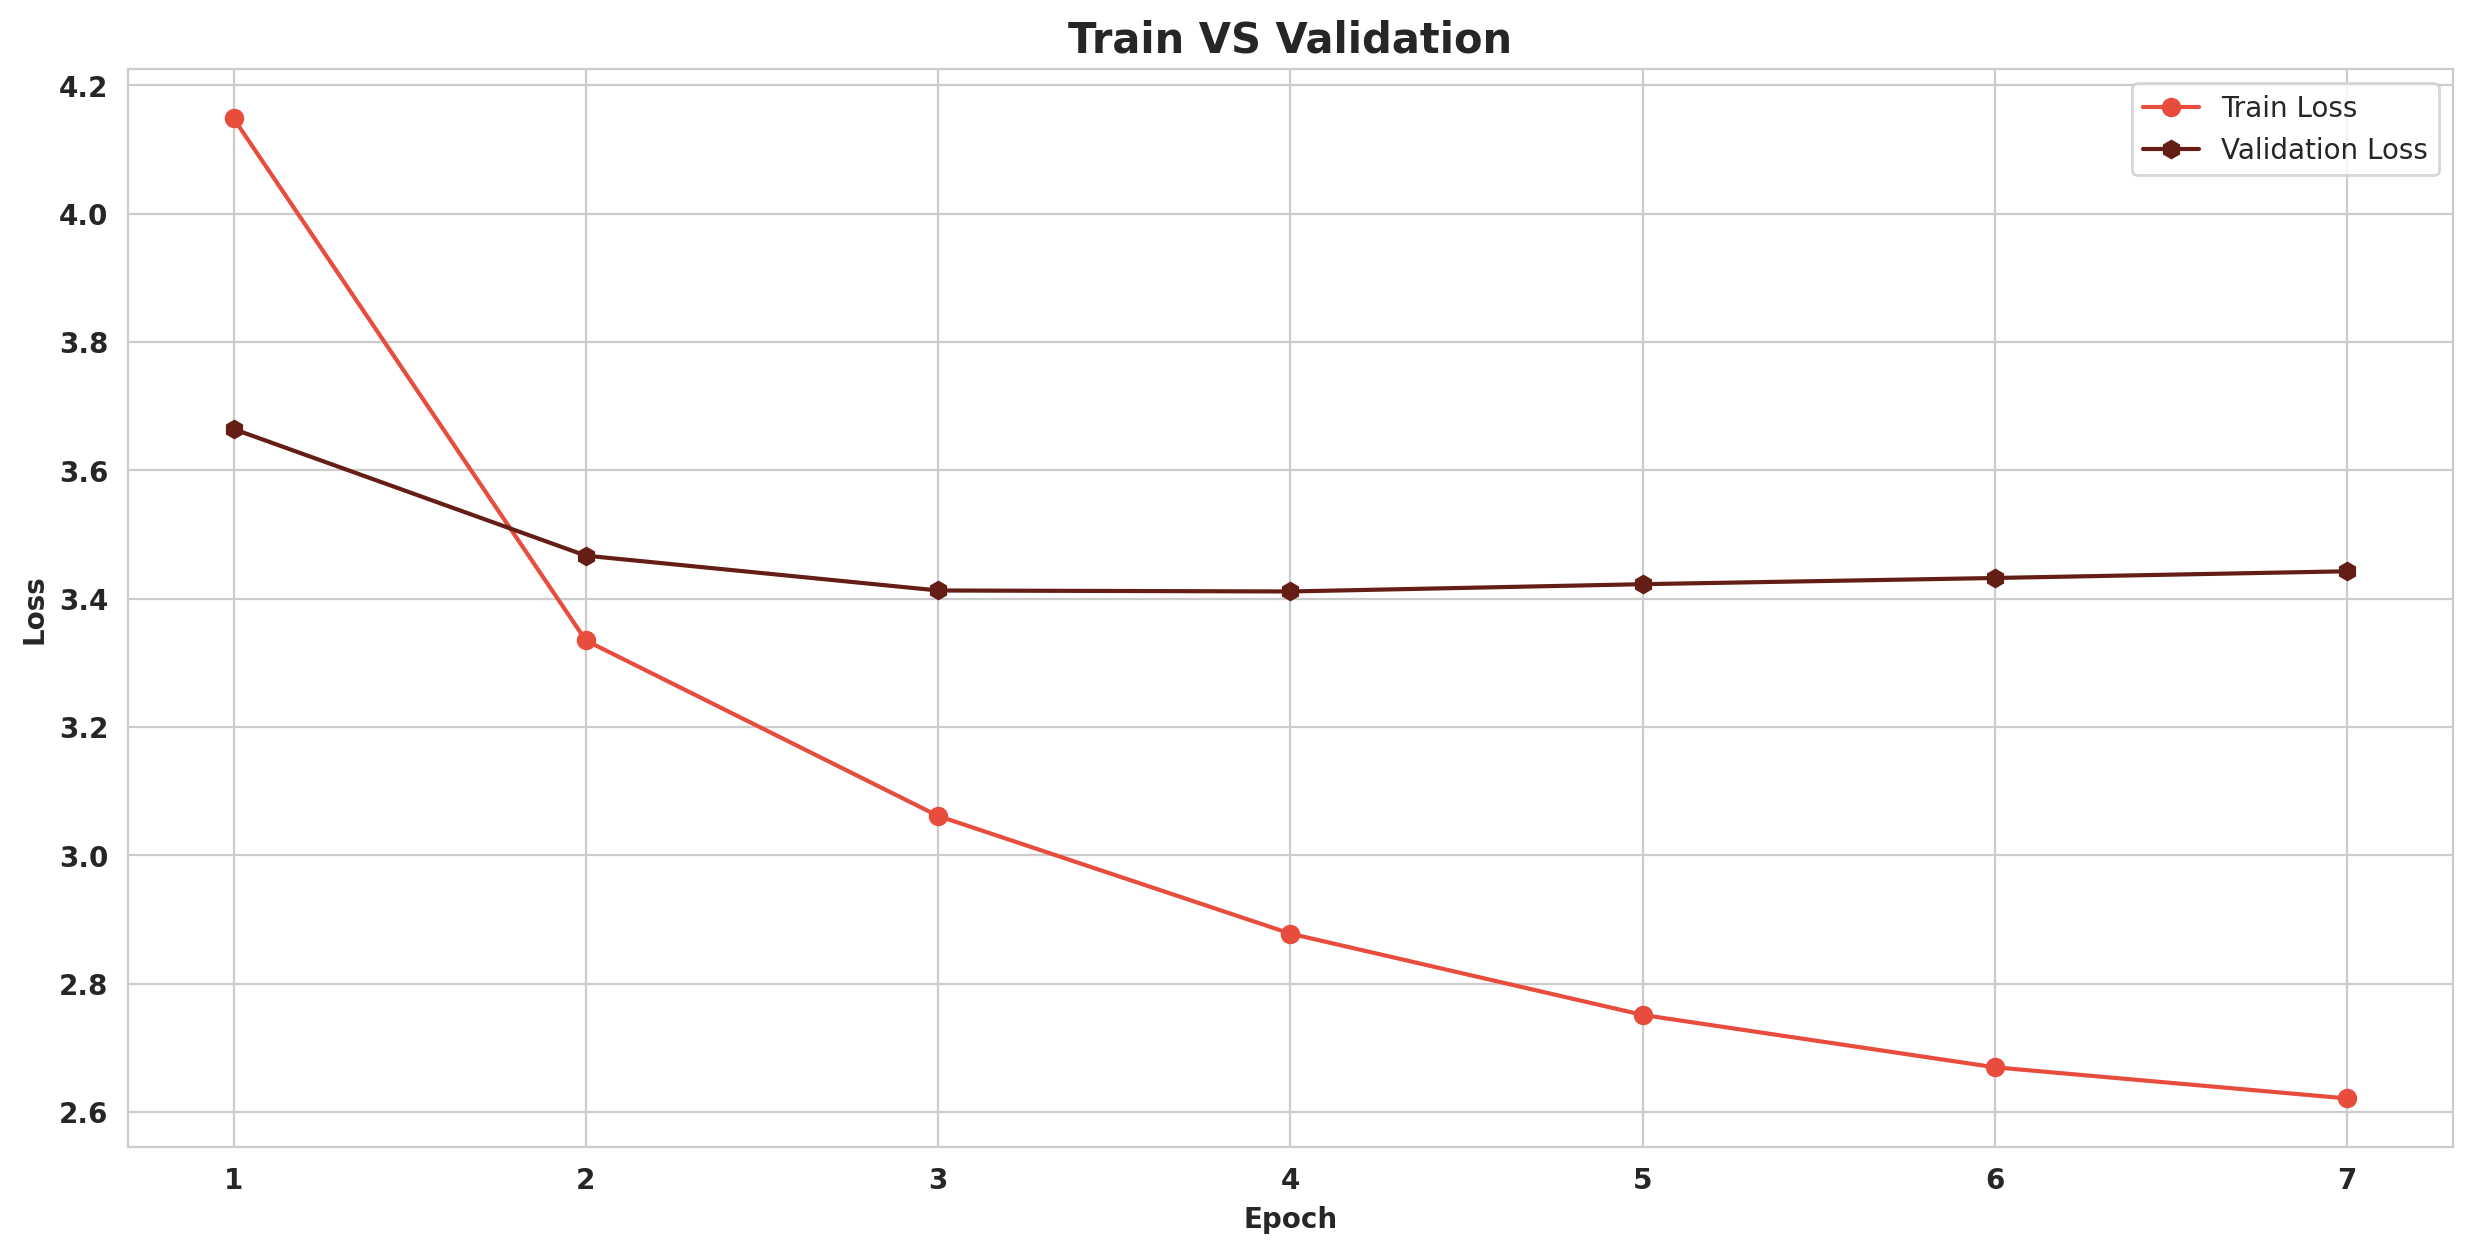

In [52]:
plt.figure (figsize = (15, 7), dpi = 200)
sns.set_style ('whitegrid')
plt.plot ([x+1 for x in range (len (history.history ['loss']))], history.history ['loss'], color = '#E74C3C', marker = 'o')
plt.plot ([x+1 for x in range (len (history.history ['loss']))], history.history ['val_loss'], color = '#641E16', marker = 'h')
plt.title ('Train VS Validation', fontsize = 15, fontweight = 'bold')
plt.xticks (fontweight = 'bold')
plt.yticks (fontweight = 'bold')
plt.xlabel ('Epoch', fontweight = 'bold')
plt.ylabel ('Loss', fontweight = 'bold')
plt.legend (['Train Loss', 'Validation Loss'], loc = 'best')
plt.show()

In [54]:
def beam_search_generator (model, image_features, K_beams = 3, log = False):
    start = [tokenizer.word_index ['start']]
    start_word = [[start, 0.0]]
    for _ in range (max_caption_length):
        temp = []
        for s in start_word:
            sequence = pad_sequences ([s[0]], maxlen = max_caption_length, padding = 'post')
            preds = model.predict ([image_features.reshape (1, cnn_output_dim), sequence], verbose = 0)
            word_preds = np.argsort (preds[0]) [-K_beams:]
            for w in word_preds:
                next_cap, prob = s [0] [:], s[1]
                next_cap.append(w)
                prob += np.log (preds [0] [w]) if log else preds [0] [w]
                temp.append ([next_cap, prob])
        start_word = sorted (temp, key = lambda l: l[1], reverse = True) [:K_beams]
    final_sequence = start_word [0] [0]
    captions_ = [tokenizer.index_word.get (i, '') for i in final_sequence]
    final_caption = []
    for word in captions_:
        if word == 'end':
            break
        final_caption.append (word)
    return ' '.join(final_caption[1:])

In [55]:
caption_model.save ("caption_model.h5")
caption_model.save_weights ("caption_model.weights.h5")

In [57]:
inf = build_model (vocab_size, max_caption_length, cnn_output_dim)
inf.load_weights ("caption_model.weights.h5")
features = extract_image_features (InceptionV3_model, '/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg')
caption = beam_search_generator (model = inf, image_features = features, K_beams = 3, log = True)
caption

'a black and white dog jumps over a dog'

# INFERENCE

In [61]:
features = extract_image_features (InceptionV3_model, '/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg')
caption = beam_search_generator (caption_model, features, K_beams = 3, log = True)

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
generated_captions = {}
for image_ID in Test_Image_Features:
    cap = beam_search_generator (caption_model, image_features = Test_Image_Features [image_ID], K_beams = 3)
    generated_captions [image_ID] = cap
smoothie = SmoothingFunction().method4
bleu1_scores, bleu4_scores = [], []
for image_ID in generated_captions:
    candidate = generated_captions[image_ID].split()
    img_key = image_ID.split ('.')[0]
    if img_key not in image_captions:
        continue
    references = [ref.split() for ref in image_captions[img_key]]
    bleu1 = sentence_bleu (references, candidate, weights = (1, 0, 0, 0), smoothing_function = smoothie)
    bleu4 = sentence_bleu (references, candidate, weights = (0.25, 0.25, 0.25, 0.25), smoothing_function = smoothie)
    bleu1_scores.append (bleu1)
    bleu4_scores.append (bleu4)
avg_bleu1 = sum (bleu1_scores) / len (bleu1_scores) if bleu1_scores else 0
avg_bleu4 = sum (bleu4_scores) / len (bleu4_scores) if bleu4_scores else 0
print (f"Average BLEU-1 Score: {avg_bleu1:.4f}")
print (f"Average BLEU-4 Score: {avg_bleu4:.4f}")